In [1]:
import sys
sys.path.append('/Users/ianleefmans/Desktop/stock-sentiment/utils')
from data import Database, ScrapeWSB, Stock
from datahelper import PostDataset, CommentDataset, get_indices
from torch.utils.data import DataLoader
from inference import RunInference
from models import FineTuneBaseModel, FineTuneClassifier
%cd /Users/ianleefmans/Desktop/stock-sentiment

/Users/ianleefmans/Desktop/stock-sentiment


In [2]:
import transformers
import torch
from transformers import BertTokenizer, BertForSequenceClassification

### DB Queries

In [4]:

db = Database()
db.use_database('DB1')

print(db.query('show tables;'))

connection established
[(datetime.datetime(2021, 10, 6, 18, 26, 27),)]
[('COMMENTS',), ('POSTS',), ('STOCKS',)]


In [7]:
db.query("SELECT * FROM STOCKS WHERE STOCK_ID='AMC' AND LAST_SCRAPED >= DATE_SUB(NOW(),INTERVAL 55 MINUTE)")

[('AMC', datetime.datetime(2021, 6, 6, 22, 15, 44))]

In [16]:
db.query("SELECT POST_ID FROM POSTS WHERE STOCK_ID='{}' AND LAST_SCRAPED >= DATE_SUB((SELECT LAST_SCRAPED FROM STOCKS WHERE STOCK_ID = '{}'), INTERVAL {} HOUR);".format('BB', 'BB', 6))



[('nx2ihx',),
 ('nxcb5h',),
 ('nxp5r6',),
 ('nxtjj4',),
 ('nxv9jr',),
 ('nxx9sz',),
 ('ny01wx',),
 ('nz6tgd',),
 ('nzf0mj',),
 ('nzjcfg',)]

In [86]:
db.query("SELECT POST_ID FROM POSTS WHERE STOCK_ID='{}' AND LAST_SCRAPED >= DATE_SUB((SELECT LAST_SCRAPED FROM STOCKS WHERE STOCK_ID = '{}'),INTERVAL {} HOUR);".format('AAPL','AAPL',6))



[('nv0h06',)]

In [85]:
db.query("SELECT LAST_SCRAPED FROM POSTS WHERE LAST_SCRAPED >= DATE_SUB((SELECT LAST_SCRAPED FROM STOCKS WHERE STOCK_ID = 'AAPL'),INTERVAL 6 HOUR);")
         
         
         


[(datetime.datetime(2021, 6, 14, 18, 21, 27),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 43),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 43),),
 (datetime.datetime(2021, 6, 14, 14, 27, 43),),
 (datetime.datetime(2021, 6, 14, 14, 27, 43),)]

### Running Inference

In [2]:
indices = get_indices("GME", inference=True, scrape_time=6)

connection established
[(datetime.datetime(2021, 10, 6, 19, 48, 59),)]


In [3]:
post_train = PostDataset(512, indices['post_ids'])



connection established
[(datetime.datetime(2021, 10, 6, 19, 49, 1),)]


In [4]:
post_trainloader = DataLoader(
    dataset=post_train, 
    batch_size=3, 
    num_workers=0,
    shuffle=True
    )

In [5]:
sample = iter(post_trainloader).next()

In [6]:
sample


{'post': ['GIANT $RUN LOVING APE BALLS OUT.....$BB $AMC $GME',
  'Jim Cramer WSB FOMO- GME and AMC bull!',
  'Daily option statistics for AMC, CLNE, BB, WISH, GME, WKHS, CLOV, PLTR, CLF, and others.'],
 'post_input_ids': tensor([[ 101,  144, 9984,  ...,    0,    0,    0],
         [ 101, 3104,  140,  ...,    0,    0,    0],
         [ 101, 5732, 5146,  ...,    0,    0,    0]]),
 'post_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'target': tensor([-1, -1, -1]),
 'date': tensor([1.6240e+09, 1.6240e+09, 1.6240e+09], dtype=torch.float64)}

In [7]:
model = FineTuneClassifier()

out = model(input_ids=sample['post_input_ids'], attention_masks=sample['post_attention_mask'])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [8]:
out

tensor([[0.5016, 0.4984],
        [0.5107, 0.4893],
        [0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)

### Stock Predictions

In [2]:
from inference import RunInference

run =RunInference('BB')
output = run.evaluate()

connection established
[(datetime.datetime(2021, 10, 17, 19, 3, 39),)]
connection established
[(datetime.datetime(2021, 10, 17, 19, 3, 41),)]


Determining Sentiment From Posts:   0%|          | 0/1 [00:00<?, ?it/s]

connection established
[(datetime.datetime(2021, 10, 17, 19, 3, 43),)]


Determining Sentiment From Comments: 100%|██████████| 1/1 [00:08<00:00,  8.51s/it]


In [3]:
output

{'avg_post_probs': tensor([0.6173, 0.3827]),
 'avg_comment_probs': tensor([0.9472, 0.0528]),
 'all_post_probs': tensor([[9.9990e-01, 1.0076e-04],
         [9.9986e-01, 1.3931e-04],
         [4.8800e-03, 9.9512e-01],
         [8.2133e-02, 9.1787e-01],
         [9.9992e-01, 8.2550e-05]]),
 'all_comment_probs': tensor([[0.8430, 0.1570],
         [0.9635, 0.0365],
         [0.9782, 0.0218],
         [0.9653, 0.0347],
         [0.9859, 0.0141]]),
 'all_post_dates': tensor([1.6343e+09, 1.6342e+09, 1.6342e+09, 1.6343e+09, 1.6342e+09],
        dtype=torch.float64),
 'all_comment_dates': tensor([1.6343e+09, 1.6343e+09, 1.6342e+09, 1.6342e+09, 1.6342e+09],
        dtype=torch.float64),
 'max_post_prob': 0.9951199889183044,
 'max_comment_prob': 0.15702766180038452,
 'max_post': 'yolo bb',
 'max_comment': '\n**User Report**| | | |\n:--|:--|:--|:--\n**Total Submissions**|423|**First Seen In WSB**|5 years ago\n**Total Comments**|32|**Previous DD**|[x](https://www.reddit.com/r/wallstreetbets/comments

In [4]:
from forecast import Forecast

get_stock = Forecast("GME", output)

100%|██████████| 777/777 [00:01<00:00, 412.16it/s]


In [38]:
preds = get_stock.arima(periods=200)


/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [10]:
df = get_stock.sentiment


In [42]:
import datetime as dt

str(df.iloc[0].date)[:-3]

'2021-10-14 00:06'

In [40]:
df.date.dt.round('s')

0   2021-10-14 00:06:40
1   2021-10-14 14:00:00
2   2021-10-14 22:20:00
3   2021-10-15 12:13:20
4   2021-10-15 23:20:00
Name: date, dtype: datetime64[ns]

In [30]:
labels2 = ['a', 'b', 'c', 'd', 'e']

In [15]:
from matplotlib import pyplot as plt


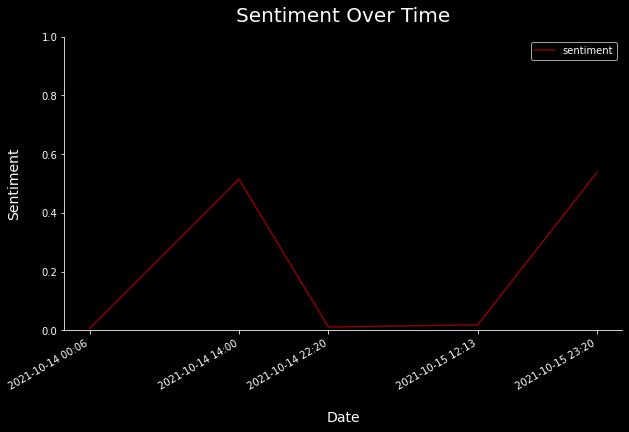

In [52]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(10,6))


get_stock.sentiment.plot.line(ax=ax, x='date', y='sentiment', color='darkred')

ticks = get_stock.sentiment.date
labels = [str(i)[:-3] for i in get_stock.sentiment.date]

ax.set_title("Sentiment Over Time", fontdict={'fontsize': 20}, pad = 15)
ax.set_xlabel('Date', fontsize=14, labelpad=20)
ax.set_ylabel('Sentiment', fontsize=14, labelpad=20)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.set_ylim(bottom=0, top=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);



In [ ]:
mod = ARIMA(endog=data.close, exog = self.stock_data.highlow_percent, order=(1, 0, 0))

In [12]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(endog=data.sentiment, order=(1, 0, 0))

In [13]:
res = mod.fit()

/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [56]:
predictions = []
def pred(df, count):
    if count == 0:
        return
    
    mod = ARIMA(endog=df, order=(1, 0, 0))
    res = mod.fit()
    
    predictions.append(float(res.forecast()))
    
    
    pred(df+[float(res.forecast())], count-1)



In [57]:
pred(list(data.sentiment), 10)

/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.

In [130]:
len(predictions)

10

In [58]:
predictions

[0.7995407913533179,
 0.7995407770139782,
 0.7995407793797036,
 0.7995407826003444,
 0.7995407878415857,
 0.7995407945813624,
 0.7995408025039776,
 0.7995408113972577,
 0.7995408211084032,
 0.7995408315218733]

In [116]:
predictions2 = []
def pred2(df1, df2):
    if len(df1)==len(df2):
        return
    
    mod = ARIMA(endog=df1, exog = df2[0:len(df1), 0], order=(1, 0, 0))
    res = mod.fit()
    
    predictions2.append(res.forecast(exog=[df2[len(df1)-1, 0]]))
    
    
    pred2(df1+[float(res.forecast(exog=[df2[len(df1)-1, 0]]))], df2)

In [120]:
pred2(list(data.close), np.add(np.array(list(data.sentiment)+predictions).reshape(-1, 1), np.random.randn(len(list(data.sentiment)+predictions), 1).reshape(-1, 1)))


